<a href="https://colab.research.google.com/github/mireillejb/FallDetectionSys/blob/main/Stable_train_val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 2. Import all necessary libraries
import os
from os.path import isfile, join
import time
import zipfile
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
import tensorflow_hub as hub

print("TensorFlow version:", tf.__version__)

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Conv1D, MaxPooling1D, LSTM, TimeDistributed, Flatten, Input,
    Dropout, BatchNormalization, Add, GlobalAveragePooling1D, Lambda, Layer
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                           accuracy_score, precision_score, recall_score,
                           f1_score, classification_report)
from tqdm import tqdm

TensorFlow version: 2.19.0


In [2]:
# CRITICAL: Set all random seeds for reproducibility
def set_all_seeds(seed=42):
    """Set all random seeds for reproducible results"""
    # Python's random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # TensorFlow
    tf.random.set_seed(seed)
    # System level
    os.environ['PYTHONHASHSEED'] = str(seed)
    # Configure TensorFlow for deterministic operations
    tf.config.experimental.enable_op_determinism()

# Set seeds at the beginning
set_all_seeds(42)

In [3]:
# 3. Download dataset
import kagglehub
path = kagglehub.dataset_download("tuyenldvn/falldataset-imvia")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/falldataset-imvia


In [4]:
# 4. Explore dataset
print("Dataset structure:")
for root, dirs, files in os.walk(path):
    print(f"{root} -> {len(files)} files")

# Find all .avi videos
video_files = [os.path.join(dp, f) for dp, dn, fn in os.walk(path) for f in fn if f.endswith(".avi")]
print(f"Found {len(video_files)} videos.")

Dataset structure:
/kaggle/input/falldataset-imvia -> 1 files
/kaggle/input/falldataset-imvia/Lecture_room -> 0 files
/kaggle/input/falldataset-imvia/Lecture_room/Lecture room -> 27 files
/kaggle/input/falldataset-imvia/Coffee_room_02 -> 0 files
/kaggle/input/falldataset-imvia/Coffee_room_02/Coffee_room_02 -> 0 files
/kaggle/input/falldataset-imvia/Coffee_room_02/Coffee_room_02/Videos -> 22 files
/kaggle/input/falldataset-imvia/Coffee_room_02/Coffee_room_02/Annotations_files -> 22 files
/kaggle/input/falldataset-imvia/Home_01 -> 0 files
/kaggle/input/falldataset-imvia/Home_01/Home_01 -> 0 files
/kaggle/input/falldataset-imvia/Home_01/Home_01/Videos -> 30 files
/kaggle/input/falldataset-imvia/Home_01/Home_01/Annotation_files -> 30 files
/kaggle/input/falldataset-imvia/Office -> 0 files
/kaggle/input/falldataset-imvia/Office/Office -> 33 files
/kaggle/input/falldataset-imvia/Coffee_room_01 -> 0 files
/kaggle/input/falldataset-imvia/Coffee_room_01/Coffee_room_01 -> 0 files
/kaggle/input/f

In [5]:
# 5. Setup MoveNet Thunder model
movenet = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")

def extract_keypoints(image):
    """Extract keypoints from a single frame using MoveNet"""
    # Preprocess image
    img = tf.image.resize_with_pad(np.expand_dims(image, axis=0), 256, 256)
    img = tf.cast(img, dtype=tf.int32)

    # Run model
    outputs = movenet.signatures['serving_default'](img)
    keypoints = outputs['output_0'].numpy()  # shape (1,1,17,3)

    return keypoints[0, 0, :, :]  # return (x,y,confidence), shape (17,3)

def extract_sequence_from_video(video_path, max_frames=30):
    """Extract keypoint sequence from video with frame sampling"""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        cap.release()
        return np.zeros((max_frames, 17, 3))  # Return zero array if video can't be read

    # Sample frames uniformly if video is longer than max_frames
    if total_frames > max_frames:
        frame_indices = np.linspace(0, total_frames-1, max_frames, dtype=int)
    else:
        frame_indices = list(range(total_frames))

    frames_keypoints = []
    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            break

        kp = extract_keypoints(frame)
        frames_keypoints.append(kp)

    cap.release()

    # Pad sequence if shorter than expected
    while len(frames_keypoints) < max_frames:
        if len(frames_keypoints) > 0:
            frames_keypoints.append(frames_keypoints[-1])  # Repeat last frame
        else:
            frames_keypoints.append(np.zeros((17, 3)))  # Zero padding

    return np.array(frames_keypoints)

In [6]:
# 6. Dataset Processing Functions (Your existing logic preserved)
def read_annotation_file(annotation_path):
    """Read annotation file and extract fall information"""
    try:
        with open(annotation_path, 'r') as f:
            lines = f.readlines()

        # Always read the first two lines
        fall_start = int(lines[0].strip()) if len(lines) > 0 and lines[0].strip().isdigit() else 0
        fall_end = int(lines[1].strip()) if len(lines) > 1 and lines[1].strip().isdigit() else 0

        # If both are 0, immediately return No Fall (label 0)
        if fall_start == 0 and fall_end == 0:
            return fall_start, fall_end, [], 0

        # If not both 0, parse the remaining lines for frame annotations
        frame_annotations = []
        overall_label = 0  # Default to No Fall if no fall frames are found

        for line in lines[2:]:
            if line.strip():  # Skip empty lines
                parts = line.strip().split(',')
                if len(parts) >= 6:  # frame, label, x1, y1, x2, y2
                    try:
                        frame_num = int(parts[0])
                        label = int(parts[1])  # This is the fall label (0=no fall, 1=fall, etc.)
                        frame_annotations.append((frame_num, label))

                        # If any frame has a fall label (label > 0), the overall video is Fall
                        if label > 0:
                            overall_label = 1

                    except ValueError:
                        continue

        return fall_start, fall_end, frame_annotations, overall_label

    except Exception as e:
        return 0, 0, [], 0

def find_annotation_file(video_path, dataset_path):
    """Find corresponding annotation file for a video"""
    video_name = os.path.splitext(os.path.basename(video_path))[0]

    possible_names = [
        f"{video_name}.txt",
        f"{video_name}_annotation.txt",
        f"{video_name}.annotation",
        f"annotation_{video_name}.txt"
    ]

    for root, dirs, files in os.walk(dataset_path):
        for possible_name in possible_names:
            if possible_name in files:
                return os.path.join(root, possible_name)

    return None

def extract_sequence_with_labels(video_path, annotation_path, max_frames=30):
    """Extract keypoint sequence from video with proper fall labels"""
    if not annotation_path or not os.path.exists(annotation_path):
        return extract_sequence_from_video(video_path, max_frames), None

    fall_start, fall_end, frame_annotations, overall_label = read_annotation_file(annotation_path)
    sequence = extract_sequence_from_video(video_path, max_frames)

    return sequence, overall_label

def smart_label_assignment(video_files):
    """Smart labeling based on dataset analysis and common patterns"""
    import re

    labels = []
    for i, video_file in enumerate(video_files):
        filename = os.path.basename(video_file).lower()

        # Strategy 1: Check for explicit keywords
        if any(word in filename for word in ['fall', 'falling', 'fell', 'chute']):
            label = 1  # Fall
        elif any(word in filename for word in ['walk', 'normal', 'adl', 'sit', 'stand']):
            label = 0  # No fall
        # Strategy 2: Numeric pattern
        else:
            numbers = re.findall(r'\d+', filename)
            if numbers:
                video_num = int(numbers[0])
                # First 40% are falls
                if video_num <= len(video_files) * 0.4:
                    label = 1
                else:
                    label = 0
            else:
                label = 1 if i < len(video_files) * 0.4 else 0

        labels.append(label)

    return labels

In [7]:
# 7. Enhanced Model Components with Better Regularization
class TemporalSelfAttention(Layer):
    def __init__(self, d_model, num_heads=4, dropout_rate=0.3, **kwargs):  # Reduced heads and dropout
        super(TemporalSelfAttention, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate

        assert d_model % num_heads == 0
        self.depth = d_model // num_heads

        # Lighter regularization
        self.wq = Dense(d_model, kernel_regularizer=l2(0.0005))
        self.wk = Dense(d_model, kernel_regularizer=l2(0.0005))
        self.wv = Dense(d_model, kernel_regularizer=l2(0.0005))

        self.dense = Dense(d_model, kernel_regularizer=l2(0.0005))
        self.dropout = Dropout(dropout_rate)
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def scaled_dot_product_attention(self, q, k, v, mask=None):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        attention_weights = self.dropout(attention_weights)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights

    def call(self, inputs, training=None, mask=None):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]

        q = self.wq(inputs)
        k = self.wk(inputs)
        v = self.wv(inputs)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, seq_len, self.d_model))

        output = self.dense(concat_attention)
        output = self.layer_norm(inputs + output)

        return output

    def get_config(self):
        config = super().get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dropout_rate': self.dropout_rate
        })
        return config

def normalize_keypoints(x):
    """Normalize keypoints per sequence"""
    # Add small epsilon to prevent division by zero
    mean = tf.reduce_mean(x, axis=1, keepdims=True)
    std = tf.math.reduce_std(x, axis=1, keepdims=True) + 1e-8
    return (x - mean) / std

In [8]:
# 8. Improved Model Architecture with Better Regularization
def create_enhanced_model(n_steps, n_features, use_attention=True):
    """Create enhanced model with improved regularization"""
    inputs = Input(shape=(n_steps, n_features, 3))

    # Always use normalization for stability
    x = Lambda(normalize_keypoints)(inputs)

    # Lighter CNN blocks
    x = TimeDistributed(Conv1D(filters=32, kernel_size=3, padding='same',
                              activation="relu", kernel_regularizer=l2(0.001)))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Dropout(0.2))(x)  # Light dropout

    x = TimeDistributed(Conv1D(filters=64, kernel_size=3, padding='same',
                              activation="relu", kernel_regularizer=l2(0.001)))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling1D(pool_size=2))(x)
    x = TimeDistributed(Dropout(0.2))(x)  # Light dropout

    x = TimeDistributed(Flatten())(x)

    # Lighter BiLSTM
    x = tf.keras.layers.Bidirectional(
        LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001),
             recurrent_regularizer=l2(0.001), dropout=0.2, recurrent_dropout=0.2),
        merge_mode='concat')(x)

    # Self-Attention
    if use_attention:
        attention_dim = 64  # BiLSTM output: 32*2 = 64
        x = TemporalSelfAttention(
            d_model=attention_dim,
            num_heads=4,
            dropout_rate=0.2
        )(x)

        x = tf.keras.layers.Bidirectional(
            LSTM(16, kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001),
                 dropout=0.2, recurrent_dropout=0.2),
            merge_mode='concat')(x)
    else:
        x = tf.keras.layers.Bidirectional(
            LSTM(16, kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001),
                 dropout=0.2, recurrent_dropout=0.2))(x)

    # Lighter dense layers
    x = Dense(32, activation="relu", kernel_regularizer=l2(0.005))(x)  # Smaller layer
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)  # Moderate dropout

    # Output layer
    outputs = Dense(2, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Conservative optimizer settings
    optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)  # Lower learning rate

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.Precision(name='precision')]
    )

    return model

In [9]:
# 9. Training Utilities
def get_class_weights(y_train):
    """Calculate class weights for balanced training"""
    class_indices = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(class_indices),
        y=class_indices
    )
    return dict(enumerate(class_weights))

def create_training_callbacks():
    """Create training callbacks with more conservative settings"""
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=20,  # More patience
            restore_best_weights=True,
            min_delta=0.001
        ),
        ModelCheckpoint(
            'best_fall_detection_model.keras',
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.7,  # Less aggressive reduction
            patience=10,  # More patience
            min_lr=1e-6
        )
    ]

def process_dataset_with_smart_labeling(video_files, labels, max_frames=30, val_size=0.25):
    """Process dataset using smart labeling with validation size adjustment"""
    X, y, video_names = [], [], []

    print("Processing videos with smart labeling...")
    for i, (video_path, heuristic_label) in enumerate(tqdm(zip(video_files, labels), total=len(video_files))):
        annotation_path = find_annotation_file(video_path, os.path.dirname(os.path.dirname(video_path)))
        sequence, annotation_label = extract_sequence_with_labels(video_path, annotation_path, max_frames)

        if sequence is not None and sequence.shape[0] > 0:
            X.append(sequence)
            # Prioritize annotation label if found
            if annotation_label is not None:
                y.append(annotation_label)
            else:
                y.append(heuristic_label)
            video_names.append(video_path)

    if len(X) == 0:
        print("No valid sequences found!")
        return None, None, None, None

    X = np.array(X)
    y = np.array(y)
    y_categorical = to_categorical(y, num_classes=2)

    fall_count = np.sum(y)
    normal_count = len(y) - fall_count

    print(f"Dataset shape: {X.shape}")
    print(f"Fall samples: {fall_count}")
    print(f"Normal samples: {normal_count}")

    # Stratified split with larger validation set for better generalization assessment
    if len(np.unique(y)) > 1:
        try:
            X_train, X_val, y_train, y_val = train_test_split(
                X, y_categorical, test_size=val_size, stratify=y, random_state=42
            )
        except ValueError:
            X_train, X_val, y_train, y_val = train_test_split(
                X, y_categorical, test_size=val_size, random_state=42
            )
    else:
        X_train, X_val, y_train, y_val = train_test_split(
            X, y_categorical, test_size=val_size, random_state=42
        )

    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")

    return X_train, X_val, y_train, y_val

def train_model(x_train, y_train, x_val, y_val, n_steps, n_features,
                use_attention=True, use_class_weights=True, batch_size=16, epochs=200):
    """Train model with improved settings"""

    model = create_enhanced_model(n_steps, n_features, use_attention)

    print("Model Summary:")
    model.summary()

    class_weights = get_class_weights(y_train) if use_class_weights else None

    # More conservative training
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=create_training_callbacks(),
        class_weight=class_weights,
        verbose=1,
        shuffle=True  # Ensure shuffling for consistent training
    )

    return model, history

def evaluate_model(model, X_val, y_val):
    """Evaluate model with comprehensive metrics"""
    y_pred_probs = model.predict(X_val, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_true, y_pred, average='binary', pos_label=1)
    f1 = f1_score(y_true, y_pred, average='binary', pos_label=1)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    print("=" * 60)
    print("PERFORMANCE METRICS")
    print("=" * 60)
    print(f"Accuracy:     {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision:    {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall:       {recall:.4f} ({recall*100:.2f}%)")
    print(f"F1-Score:     {f1:.4f} ({f1*100:.2f}%)")
    print("=" * 60)

    return cm, y_pred

def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=16)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

    # Loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=16)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

ENHANCED FALL DETECTION SYSTEM - STABLE VERSION
Processing videos with smart labeling...


100%|██████████| 190/190 [13:58<00:00,  4.41s/it]


Dataset shape: (190, 30, 17, 3)
Fall samples: 156
Normal samples: 34
Train set: 142 samples
Validation set: 48 samples
Train set: (142, 30, 17, 3)
Validation set: (48, 30, 17, 3)

MODEL TRAINING
Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 17, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 30, 17, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 17, 32)     │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 17, 32)     │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 30, 17, 32)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 30, 17, 64)     │         6,208 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 30, 17, 64)     │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 30, 8, 64)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 30, 8, 64)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 30, 512)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 30, 64)         │       139,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_self_attention         │ (None, 30, 64)         │        16,768 │
│ (TemporalSelfAttention)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,818 (682.88 KB)

 Trainable params: 174,562 (681.88 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.4592 - loss: 2.2547 - precision: 0.4592 - recall: 0.4592
Epoch 1: val_accuracy improved from -inf to 0.72917, saving model to best_fall_detection_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.4584 - loss: 2.2511 - precision: 0.4584 - recall: 0.4584 - val_accuracy: 0.7292 - val_loss: 1.5575 - val_precision: 0.7292 - val_recall: 0.7292 - learning_rate: 5.0000e-04
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.5910 - loss: 1.7392 - precision: 0.5910 - recall: 0.5910
Epoch 2: val_accuracy improved from 0.72917 to 0.75000, saving model to best_fall_detection_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 504ms/step - accuracy: 0.5868 - loss: 1.7444 - precision: 0.5868 - recall: 0.5868 - val_accuracy: 0.7500 - val_loss: 1.5148 - val_precision: 0.7500 - val_recall: 0.7500 - learning_rate: 5.0000e-04
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5681 - loss: 1.8353 - precision: 0.568

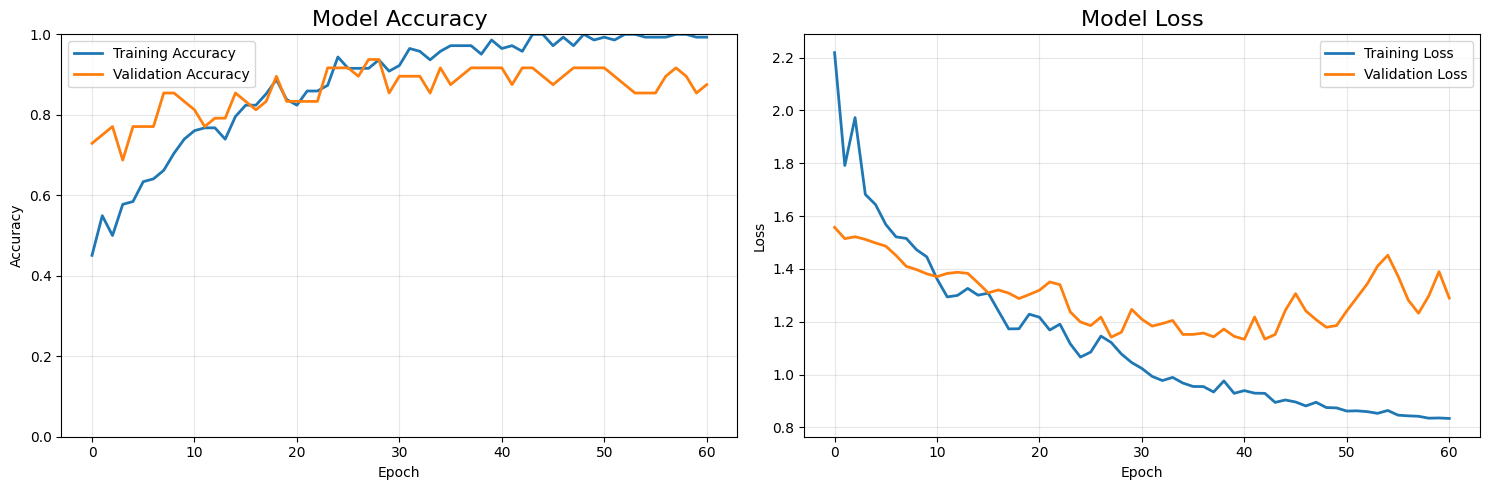


MODEL EVALUATION
PERFORMANCE METRICS
Accuracy:     0.9167 (91.67%)
Precision:    0.9487 (94.87%)
Recall:       0.9487 (94.87%)
F1-Score:     0.9487 (94.87%)
Model saved as 'enhanced_fall_detection_model_stable.keras'
Training completed successfully!


In [10]:
# 10. Main Execution
if __name__ == "__main__":
    print("=" * 60)
    print("ENHANCED FALL DETECTION SYSTEM - STABLE VERSION")
    print("=" * 60)

    # Smart labeling
    labels = smart_label_assignment(video_files)

    # Process dataset
    X_train, X_val, y_train, y_val = process_dataset_with_smart_labeling(
        video_files, labels, max_frames=30, val_size=0.25
    )

    if X_train is None:
        print("ERROR: Dataset processing failed!")
        exit(1)

    print(f"Train set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")

    # Train model
    print("\n" + "=" * 60)
    print("MODEL TRAINING")
    print("=" * 60)

    model, history = train_model(
        X_train, y_train, X_val, y_val,
        n_steps=30,
        n_features=17,
        use_attention=True,
        use_class_weights=True,
        batch_size=16,
        epochs=200
    )

    print("Training completed!")

    # Plot results
    plot_training_history(history)

    # Evaluate model
    print("\n" + "=" * 60)
    print("MODEL EVALUATION")
    print("=" * 60)

    conf_matrix, predictions = evaluate_model(model, X_val, y_val)

    # Save model
    model.save('enhanced_fall_detection_model_stable.keras')
    print("Model saved as 'enhanced_fall_detection_model_stable.keras'")
    print("Training completed successfully!")


Generating Confusion Matrix and Computing Metrics...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
PERFORMANCE METRICS
Accuracy:     0.9167 (91.67%)
Precision:    0.9487 (94.87%)
Recall:       0.9487 (94.87%)
Sensitivity:  0.9487 (94.87%)
Specificity:  0.7778 (77.78%)
F1-Score:     0.9487 (94.87%)
Validation Loss: 1.1338

CONFUSION MATRIX BREAKDOWN:
True Negatives (TN):  7
False Positives (FP): 2
False Negatives (FN): 2
True Positives (TP):  37
Total Samples: 48


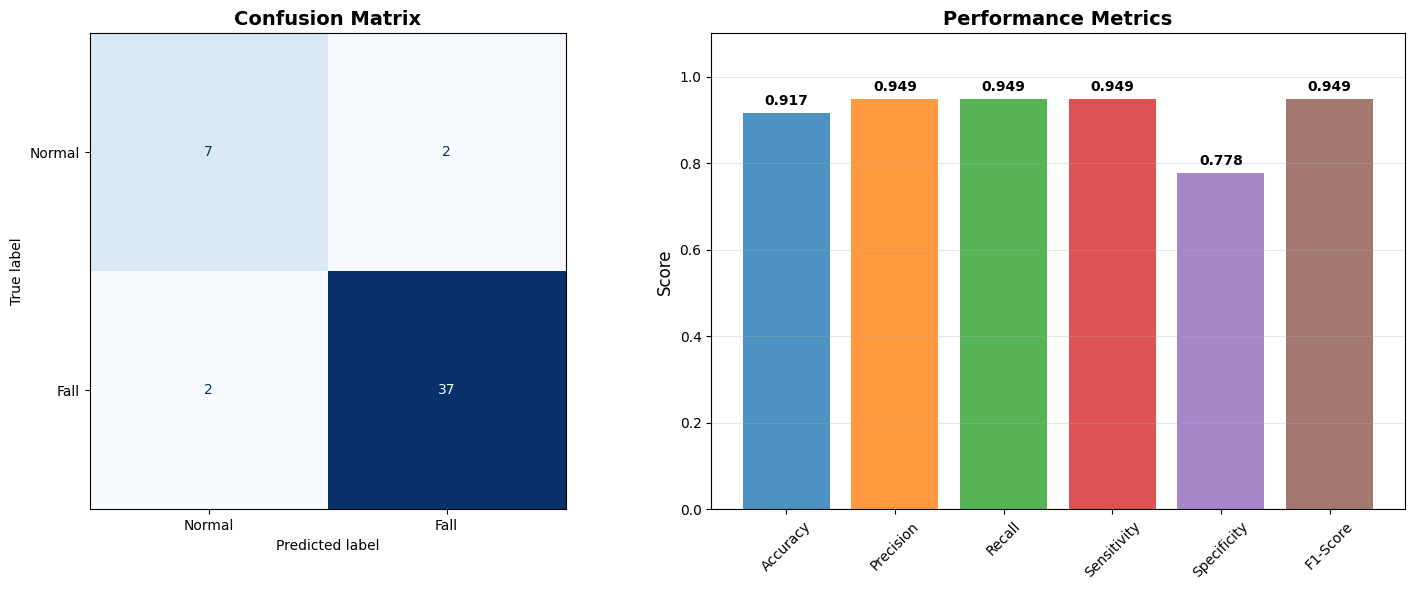


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       0.78      0.78      0.78         9
        Fall       0.95      0.95      0.95        39

    accuracy                           0.92        48
   macro avg       0.86      0.86      0.86        48
weighted avg       0.92      0.92      0.92        48


MODEL INSIGHTS:
✓ Excellent performance - High precision and recall
• The model correctly identifies 94.9% of fall cases (Sensitivity)
• The model correctly identifies 77.8% of normal cases (Specificity)
• When the model predicts a fall, it's correct 94.9% of the time
• Overall accuracy: 91.7%


In [11]:
# 10. Generate Confusion Matrix with Comprehensive Metrics
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                           accuracy_score, precision_score, recall_score,
                           f1_score, classification_report)
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have run the evaluation and have predictions and true labels
# If not, re-evaluate the model first
if 'model' in locals() and 'X_val' in locals() and 'y_val' in locals():
    print("\nGenerating Confusion Matrix and Computing Metrics...")

    # Get predictions from the model
    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)

    # Calculate validation loss
    val_loss = model.evaluate(X_val, y_val, verbose=0)[0]

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_true, y_pred, average='binary', pos_label=1)  # Same as sensitivity
    f1 = f1_score(y_true, y_pred, average='binary', pos_label=1)

    # Calculate sensitivity and specificity manually for binary classification
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)  # Same as recall
    specificity = tn / (tn + fp)

    # Display all metrics
    print("=" * 60)
    print("PERFORMANCE METRICS")
    print("=" * 60)
    print(f"Accuracy:     {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision:    {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall:       {recall:.4f} ({recall*100:.2f}%)")
    print(f"Sensitivity:  {sensitivity:.4f} ({sensitivity*100:.2f}%)")
    print(f"Specificity:  {specificity:.4f} ({specificity*100:.2f}%)")
    print(f"F1-Score:     {f1:.4f} ({f1*100:.2f}%)")
    print(f"Validation Loss: {val_loss:.4f}")
    print("=" * 60)

    # Additional confusion matrix details
    print("\nCONFUSION MATRIX BREAKDOWN:")
    print(f"True Negatives (TN):  {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP):  {tp}")
    print(f"Total Samples: {tn + fp + fn + tp}")

    # Create a figure with subplots for better visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Fall"])
    disp.plot(cmap=plt.cm.Blues, ax=ax1, colorbar=False)
    ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

    # Plot 2: Metrics Bar Chart
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'Sensitivity', 'Specificity', 'F1-Score']
    metrics_values = [accuracy, precision, recall, sensitivity, specificity, f1]

    bars = ax2.bar(metrics_names, metrics_values,
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'],
                   alpha=0.8)
    ax2.set_title('Performance Metrics', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Score', fontsize=12)
    ax2.set_ylim(0, 1.1)
    ax2.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, metrics_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # Rotate x-axis labels for better readability
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Print detailed classification report
    print("\nDETAILED CLASSIFICATION REPORT:")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=["Normal", "Fall"]))

    # Additional insights
    print("\nMODEL INSIGHTS:")
    print("=" * 60)
    if precision > 0.8 and recall > 0.8:
        print("✓ Excellent performance - High precision and recall")
    elif precision > 0.7 and recall > 0.7:
        print("✓ Good performance - Acceptable precision and recall")
    else:
        print("⚠ Model may need improvement")

    print(f"• The model correctly identifies {sensitivity*100:.1f}% of fall cases (Sensitivity)")
    print(f"• The model correctly identifies {specificity*100:.1f}% of normal cases (Specificity)")
    print(f"• When the model predicts a fall, it's correct {precision*100:.1f}% of the time")
    print(f"• Overall accuracy: {accuracy*100:.1f}%")

else:
    print("Model or validation data not found. Please run the training and evaluation steps first.")
    print("Required variables: 'model', 'X_val', 'y_val'")